<a href="https://colab.research.google.com/github/anoopsanka/retinal_oct/blob/main/notebooks/OCT_simclr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/anoopsanka/retinal_oct

Cloning into 'retinal_oct'...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 377 (delta 149), reused 182 (delta 80), pack-reused 103
Receiving objects: 100% (377/377), 253.69 MiB | 19.84 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [2]:
%%capture
# needed to use rotate....
!pip install -U tensorflow_addons

In [3]:
%cd retinal_oct

/content/retinal_oct


In [4]:
import tensorflow_datasets as tfds
from importlib.util import find_spec
if find_spec("core") is None:
    import sys
    sys.path.append('..')
    
from core.datasets import RetinaDataset

In [5]:
ds_train, ds_train_info = tfds.load('RetinaDataset', split='train', shuffle_files=True, as_supervised=True, with_info=True)
ds_test  = tfds.load('RetinaDataset', split='test', shuffle_files=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incompleteWJQY4N/retina_dataset-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incompleteWJQY4N/retina_dataset-test.tfrecord


Dataset retina_dataset downloaded and prepared to /root/tensorflow_datasets/retina_dataset/1.0.0. Subsequent calls will reuse this data.


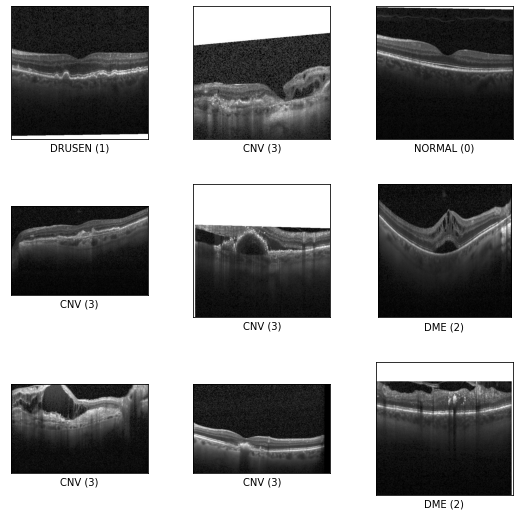

In [7]:
fig = tfds.show_examples(ds_train, ds_train_info)

In [8]:
%cd core/models/simclr

/content/retinal_oct/core/models/simclr


In [10]:
# from simclr_model import Pretrained_SimCLR_Model
import simclr_model

In [11]:
def train_classification_aug(img, lb, 
                             img_size=128, 
                             brightness_delta= 0.5,
                             contrast_delta  = 0.5,
                             saturation_delta= 0.5,
                             hue_delta       = 0.2,
                             max_rot_angle   = 45.):
  img = tf.cast(img, dtype=tf.float32)/255.
  IMG_SIZE = img_size

  angle_rad = max_rot_angle / 180. * np.pi

  padding = IMG_SIZE // 4
  precrop_shape = IMG_SIZE + padding

  img = tf.image.resize(img, (precrop_shape, precrop_shape))
  img = tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))
  img = tf.image.random_brightness(img, brightness_delta)
  img = tf.image.random_contrast  (img, 1-contrast_delta,  1+contrast_delta)
  img = tf.image.random_saturation(img, 1-saturation_delta,1+saturation_delta)
  img = tf.image.random_hue       (img, hue_delta)

  img = tf.image.random_flip_left_right(img)
  img = tfa.image.rotate(img, (tf.random.uniform(shape=(1,)) - 0.5)*2 *angle_rad )

  img = tf.clip_by_value(img, 0., 1.0)
  return img, lb #tf.one_hot(lb, 4, )

def train_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(train_classification_aug(img, lb)[0])
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, NUM_CLASSES)

def val_data_aug(img, lb):
  img = preprocess_image(img, IMG_SIZE, IMG_SIZE, 
                         is_training=True, 
                         color_distort=True, 
                         test_crop=False)
  return img, lb      

class WarmUpAndCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
  """Applies a warmup schedule on a given learning rate decay schedule."""

  def __init__(self, base_learning_rate, num_examples, 
               name=None, 
               train_epochs = 1000,
               train_batch_size = 256, 
               learning_rate_scaling='linear',
               warmup_epochs = 10,
               ):
    super(WarmUpAndCosineDecay, self).__init__()
    self.base_learning_rate = base_learning_rate
    self.num_examples = num_examples
    self._name = name
    self.learning_rate_scaling = learning_rate_scaling
    self.train_batch_size = train_batch_size
    self.warmup_epochs = warmup_epochs
    self.train_epochs  = train_epochs

  def __call__(self, step):
    with tf.name_scope(self._name or 'WarmUpAndCosineDecay'):
      warmup_steps = int(
          round(self.warmup_epochs * self.num_examples //
                self.train_batch_size))
      if self.learning_rate_scaling == 'linear':
        scaled_lr = self.base_learning_rate * self.train_batch_size / 256.
      elif self.learning_rate_scaling == 'sqrt':
        scaled_lr = self.base_learning_rate * math.sqrt(self.train_batch_size)
      else:
        raise ValueError('Unknown learning rate scaling {}'.format(
            self.learning_rate_scaling))
      learning_rate = (
          step / float(warmup_steps) * scaled_lr if warmup_steps else scaled_lr)

      # Cosine decay learning rate schedule
      total_steps = self.num_examples * self.train_epochs // self.train_batch_size + 1
      # TODO(srbs): Cache this object.
      cosine_decay = tf.keras.experimental.CosineDecay(
          scaled_lr, total_steps - warmup_steps)
      learning_rate = tf.where(step < warmup_steps, learning_rate,
                               cosine_decay(step - warmup_steps))

      return learning_rate

  def get_config(self):
    return {
        'base_learning_rate': self.base_learning_rate,
        'num_examples': self.num_examples,
    }

In [12]:
import os
import random
import numpy as np
import tensorflow as tf

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [30]:
from data_augmentation import train_classification_aug
from lr_schedule import WarmUpAndCosineDecay
import simclr_model
import tensorflow_addons as tfa

In [19]:
import importlib
import data_augmentation
importlib.reload(data_augmentation)

<module 'data_augmentation' from '/content/retinal_oct/core/models/simclr/data_augmentation.py'>

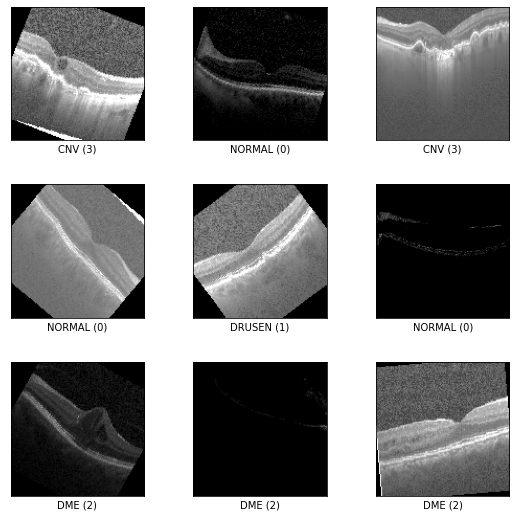

In [20]:
fig = tfds.show_examples(ds_train.map(data_augmentation.train_classification_aug), ds_train_info)

In [15]:
%%capture
!pip install wandb

In [21]:
import wandb
from wandb.keras import WandbCallback
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [22]:
run = wandb.init(project='OCT-keras-SimCLR',
                 config={
                     # and include hyperparameters and metadata
                     "learning_rate": 1e-2,
                     "epochs": 120,
                     "learning_rate_scaling": 'linear',
                     "num_examples": len(ds_train),
                     "warmup_epochs": 10,
                     "batch_size": 128,
                     "num_classes": 4,
                     "use_blur": True,
                     # ProjectionLayer Parameters
                     "proj_head_mode": 'nonlinear',
                     "proj_out_dim" : 128,
                     "num_proj_layers": 3, 
                     "ft_proj_selector": 0,
                     # Resnet_parameter
                     "resnet_depth": 18,
                     "resnet_width_multiplier": 1,
                     "resnet_se_ratio": 0.0,
                     "resnet_sk_ratio": 0.0,
                     # contrastive loss parameter
                     "hidden_norm": True,
                     "temperature" :1.0,
                     # Image Size
                     'IMG_SIZE': 256,
                 })

wandb: Currently logged in as: hisunnytang (use `wandb login --relogin` to force relogin)


In [23]:
config = run.config

In [24]:
config

{'learning_rate': 0.01, 'epochs': 120, 'learning_rate_scaling': 'linear', 'num_examples': 83489, 'warmup_epochs': 10, 'batch_size': 128, 'num_classes': 4, 'use_blur': True, 'proj_head_mode': 'nonlinear', 'proj_out_dim': 128, 'num_proj_layers': 3, 'ft_proj_selector': 0, 'resnet_depth': 18, 'resnet_width_multiplier': 1, 'resnet_se_ratio': 0.0, 'resnet_sk_ratio': 0.0, 'hidden_norm': True, 'temperature': 1.0, 'IMG_SIZE': 256}

In [25]:
import simclr_model
NUM_CLASSES = 4

In [26]:
model = simclr_model.Pretrained_SimCLR_Model(num_classes=NUM_CLASSES, 
                                             use_blur = config.use_blur,
                                             proj_head_mode = config.proj_head_mode,
                                             proj_out_dim = config.proj_out_dim,
                                             num_proj_layers = config.num_proj_layers,
                                             ft_proj_selector = config.ft_proj_selector, 
                                             resnet_depth = config.resnet_depth,
                                             resnet_width_multiplier = config.resnet_width_multiplier,
                                             resnet_se_ratio = config.resnet_se_ratio,
                                             resnet_sk_ratio = config.resnet_sk_ratio,
                                             hidden_norm = config.hidden_norm, 
                                             temperature = config.temperature)

In [27]:
input_shape_base   = (None, config.IMG_SIZE, config.IMG_SIZE, 3)
input_shape_simclr = (None, config.IMG_SIZE, config.IMG_SIZE, 6)
model.base_model.build(input_shape_base)
model.build(input_shape_simclr)
model.summary()

Model: "pretrained__sim_clr__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet (Resnet)              multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head (ProjectionH multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________


In [28]:
lr_scheduler = WarmUpAndCosineDecay(config.learning_rate, 
                                    num_examples= config.num_examples, 
                                    train_epochs= config.epochs, 
                                    train_batch_size = config.batch_size,
                                    learning_rate_scaling = config.learning_rate_scaling, 
                                    warmup_epochs = config.warmup_epochs)

In [31]:

optimizer = tfa.optimizers.LAMB(lr_scheduler,
                                weight_decay_rate=1e-6,
                                exclude_from_weight_decay=['batch_normalization', 'bias', 'head_supervised'])
model.compile(optimizer= optimizer)

In [34]:
def train_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(train_classification_aug(img, lb, img_size = config.IMG_SIZE)[0])
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, NUM_CLASSES)

def val_data_aug(img, lb):
  img = preprocess_image(img, config.IMG_SIZE, config.IMG_SIZE, 
                         is_training=True, 
                         color_distort=True, 
                         test_crop=False)
  return img, lb      

In [35]:
import tensorflow as tf
import numpy as np

In [36]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= os.path.join(wandb.run.dir, 'weights.{epoch:02d}-{contrast_acc:.2f}.hdf5'),
    save_weights_only=True,
    monitor='contrast_acc',
    mode='max',
    save_best_only=True)

In [ ]:
model.fit(ds_train.map(train_data_aug, num_parallel_calls=tf.data.AUTOTUNE).batch(config.batch_size ).prefetch(tf.data.AUTOTUNE), 
          epochs= config.epochs, 
          # validation_data = ds_test.map(train_data_aug).batch(config.batch_size),
          callbacks = [WandbCallback(), model_checkpoint_callback])

model.save_weights( os.path.join(wandb.run.dir, 'model.h5') )
run.finish()

Epoch 1/120
653/653 [==============================] - 1173s 2s/step - contrast_loss: 10.9891 - contrast_acc: 0.0206 - contrast_entropy: 4.8005 - supervised_loss: 1.2441 - supervised_acc: 0.4391
Epoch 2/120
653/653 [==============================] - 1160s 2s/step - contrast_loss: 10.6375 - contrast_acc: 0.0374 - contrast_entropy: 4.7417 - supervised_loss: 1.1764 - supervised_acc: 0.5073
Epoch 3/120
653/653 [==============================] - 1163s 2s/step - contrast_loss: 10.2276 - contrast_acc: 0.0713 - contrast_entropy: 4.7159 - supervised_loss: 0.9777 - supervised_acc: 0.6295
Epoch 4/120
653/653 [==============================] - 1174s 2s/step - contrast_loss: 10.0276 - contrast_acc: 0.0988 - contrast_entropy: 4.7101 - supervised_loss: 0.8578 - supervised_acc: 0.6745
Epoch 5/120
653/653 [==============================] - 1190s 2s/step - contrast_loss: 9.8900 - contrast_acc: 0.1544 - contrast_entropy: 4.7192 - supervised_loss: 0.7713 - supervised_acc: 0.7083
Epoch 6/120
653/653 [=====

In [ ]:
run.finish()

epoch,58
contrast_loss,10.91602
contrast_acc,0.52043
contrast_entropy,5.47675
supervised_loss,0.56334
supervised_acc,0.79169
_step,59
_runtime,32652
_timestamp,1611124263


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
contrast_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
contrast_acc,▁▁▂▃▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
contrast_entropy,█▁▁▂▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇
supervised_loss,██▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
supervised_acc,▁▂▅▆▇▇▇▇████████████████████████████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [ ]:
model.save_weights( os.path.join(wandb.run.dir, 'model.h5') )

In [ ]:
%ls

data_augmentation.py  losses.py           __pycache__/      run_simclr.py
layers.py             model.h5            resnet_blocks.py  simclr_model.py
LICENSE               projection_head.py  resnet.py         wandb/


In [ ]:
wandb.run.dir

'/content/retinal_oct/core/models/simclr/wandb/run-20210111_194553-1faetwsr/files'

In [ ]:
cd wandb/run-20210111_194553-1faetwsr/files

/content/retinal_oct/core/models/simclr/wandb/run-20210111_194553-1faetwsr/files


In [ ]:
%ls

config.yaml  model.h5    requirements.txt     wandb-summary.json
media/       output.log  wandb-metadata.json


In [ ]:
count = 0
true_count = 0
for X, y in ds_test.map(val_data_aug).batch(64):
  proj_out, logits_out = model(X, training=False)
  count += len(y)
  pred_y  = logits_out.numpy().argmax(axis=-1)
  true_y  = y.numpy()
  true_count += sum(pred_y== true_y)

In [ ]:
true_count/ count

0.8574380165289256

In [ ]:
run.finish()

epoch,29
contrast_loss,7.75491
contrast_acc,0.99376
contrast_entropy,4.12826
supervised_loss,0.42252
supervised_acc,0.84375
_step,29
_runtime,14996
_timestamp,1610409349


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
contrast_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
contrast_acc,▁▃▅▆▇▇▇███████████████████████
contrast_entropy,▁▃▄▅▆▆▆▇▇▇▇▇▇█████████████████
supervised_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
supervised_acc,▁▂▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


In [ ]:
!python run_simclr.py

2021-01-12 03:12:28.925464: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
['/content/retinal_oct/core/models/simclr', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/content/retinal_oct']
2021-01-12 03:12:32.211165: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-12 03:12:32.212351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-12 03:12:32.216266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-12 03:12:32.216858: I tensorflow/core/common_run

In [ ]:
!cd ../../../

In [ ]:
%cd ../../../

/content/retinal_oct/core/models/simclr


In [ ]:
run = wandb.init(project='OCT-keras-SimCLR',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 1e-3,
                     "epochs": 30,
                     "batch_size": 128,
                     "num_classes": 4,
                     "use_blur": True,
                     # ProjectionLayer Parameters
                     "proj_head_mode": 'nonlinear',
                     "proj_out_dim" : 128,
                     "num_proj_layers": 3,
                     "ft_proj_selector": 0,
                     # Resnet_parameter
                     "resnet_depth": 18,
                     "resnet_width_multiplier": 1,
                     "resnet_se_ratio": 0.0,
                     "resnet_sk_ratio": 0.0,
                     # contrastive loss parameter
                     "hidden_norm": True,
                     "temperature" :1.0,
                     # Image Size
                     'IMG_SIZE': 128,
                 })


config = run.config

# Initialize the model
model = simclr_model.Pretrained_SimCLR_Model(num_classes=NUM_CLASSES,
                                             use_blur = config.use_blur,
                                             proj_head_mode = config.proj_head_mode,
                                             proj_out_dim = config.proj_out_dim,
                                             num_proj_layers = config.num_proj_layers,
                                             ft_proj_selector = config.ft_proj_selector,
                                             resnet_depth = config.resnet_depth,
                                             resnet_width_multiplier = config.resnet_width_multiplier,
                                             resnet_se_ratio = config.resnet_se_ratio,
                                             resnet_sk_ratio = config.resnet_sk_ratio,
                                             hidden_norm = config.hidden_norm,
                                             temperature = config.temperature)

# Build the Model
input_shape_base   = (None, config.IMG_SIZE, config.IMG_SIZE, 3)
input_shape_simclr = (None, config.IMG_SIZE, config.IMG_SIZE, 6)
model.base_model.build(input_shape_base)
model.build(input_shape_simclr)
model.summary()

# Define Optimizer
optimizer = tfa.optimizers.LAMB(config.learning_rate)
model.compile(optimizer= optimizer)

model.fit(ds_train.map(train_data_aug).batch(config.batch_size ),
          epochs= config.epochs,
          # validation_data = ds_test.map(train_data_aug).batch(config.batch_size),
          callbacks = [WandbCallback()])


wandb: wandb version 0.10.13 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Model: "pretrained__sim_clr__model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_3 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_3 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________
Epoch 1/30
653/653 [==============================] - 497s 742ms/step - contrast_loss: 10.3107 - contrast_acc: 0.0779 - contrast_entropy: 4.7363 - supervised_loss: 1.2657 - supervised_acc: 0.4209
Epoch 2/30
653/653 [==============================] - 483s 739ms/step - contrast_loss: 9.9262 - contrast_acc: 0.1359 - contrast_entropy: 4.7211 - supervise

In [ ]:
model.save_weights( os.path.join(wandb.run.dir, 'model.h5') )
run.finish()

In [ ]:
import tensorflow_addons as tfa

def train_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append( preprocess_image(img, config.IMG_SIZE, config.IMG_SIZE, 
                                is_training=True, 
                                color_distort=True, 
                                test_crop=False) )
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, config.num_classes)

def val_data_aug(img, lb):
  img = preprocess_image(img, config.IMG_SIZE, config.IMG_SIZE, 
                         is_training=True, 
                         color_distort=True, 
                         test_crop=False)
  return img, lb

In [ ]:
run = wandb.init(project='OCT-keras-SimCLR',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 1e-3,
                     "epochs": 30,
                     "batch_size": 512,
                     "num_classes": 4,
                     "use_blur": True,
                     # ProjectionLayer Parameters
                     "proj_head_mode": 'nonlinear',
                     "proj_out_dim" : 128,
                     "num_proj_layers": 3,
                     "ft_proj_selector": 0,
                     # Resnet_parameter
                     "resnet_depth": 18,
                     "resnet_width_multiplier": 1,
                     "resnet_se_ratio": 0.0,
                     "resnet_sk_ratio": 0.0,
                     # contrastive loss parameter
                     "hidden_norm": True,
                     "temperature" :1.0,
                     # Image Size
                     'IMG_SIZE': 128,
                 })


config = run.config

# Initialize the model
model = simclr_model.Pretrained_SimCLR_Model(num_classes=NUM_CLASSES,
                                             use_blur = config.use_blur,
                                             proj_head_mode = config.proj_head_mode,
                                             proj_out_dim = config.proj_out_dim,
                                             num_proj_layers = config.num_proj_layers,
                                             ft_proj_selector = config.ft_proj_selector,
                                             resnet_depth = config.resnet_depth,
                                             resnet_width_multiplier = config.resnet_width_multiplier,
                                             resnet_se_ratio = config.resnet_se_ratio,
                                             resnet_sk_ratio = config.resnet_sk_ratio,
                                             hidden_norm = config.hidden_norm,
                                             temperature = config.temperature)

# Build the Model
input_shape_base   = (None, config.IMG_SIZE, config.IMG_SIZE, 3)
input_shape_simclr = (None, config.IMG_SIZE, config.IMG_SIZE, 6)
model.base_model.build(input_shape_base)
model.build(input_shape_simclr)
model.summary()

# Define Optimizer
optimizer = tfa.optimizers.LAMB(config.learning_rate)
model.compile(optimizer= optimizer)

model.fit(ds_train.map(train_data_aug).batch(config.batch_size ),
          epochs= config.epochs,
          callbacks = [WandbCallback()])
model.save_weights( os.path.join(wandb.run.dir, 'model.h5') )
run.finish()

Model: "pretrained__sim_clr__model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_2 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_2 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________
Epoch 1/30
164/164 [==============================] - 520s 3s/step - contrast_loss: 12.3483 - contrast_acc: 0.2155 - contrast_entropy: 6.1235 - supervised_loss: 1.3290 - supervised_acc: 0.4277
Epoch 2/30
164/164 [==============================] - 498s 3s/step - contrast_loss: 12.1404 - contrast_acc: 0.2507 - contrast_entropy: 6.1328 - supervised_los

epoch,29
contrast_loss,11.89363
contrast_acc,0.94472
contrast_entropy,6.1955
supervised_loss,0.95048
supervised_acc,0.63657
_step,29
_runtime,14881
_timestamp,1610475671


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
contrast_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
contrast_acc,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████
contrast_entropy,▁▂▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
supervised_loss,█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▁▁
supervised_acc,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▄▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


In [ ]:
run = wandb.init(project='OCT-keras-SimCLR',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 1e-2,
                     "epochs": 30,
                     "batch_size": 512,
                     "num_classes": 4,
                     "use_blur": True,
                     # ProjectionLayer Parameters
                     "proj_head_mode": 'nonlinear',
                     "proj_out_dim" : 128,
                     "num_proj_layers": 3,
                     "ft_proj_selector": 0,
                     # Resnet_parameter
                     "resnet_depth": 18,
                     "resnet_width_multiplier": 1,
                     "resnet_se_ratio": 0.0,
                     "resnet_sk_ratio": 0.0,
                     # contrastive loss parameter
                     "hidden_norm": True,
                     "temperature" :1.0,
                     # Image Size
                     'IMG_SIZE': 128,
                 })


config = run.config

# Initialize the model
model = simclr_model.Pretrained_SimCLR_Model(num_classes=NUM_CLASSES,
                                             use_blur = config.use_blur,
                                             proj_head_mode = config.proj_head_mode,
                                             proj_out_dim = config.proj_out_dim,
                                             num_proj_layers = config.num_proj_layers,
                                             ft_proj_selector = config.ft_proj_selector,
                                             resnet_depth = config.resnet_depth,
                                             resnet_width_multiplier = config.resnet_width_multiplier,
                                             resnet_se_ratio = config.resnet_se_ratio,
                                             resnet_sk_ratio = config.resnet_sk_ratio,
                                             hidden_norm = config.hidden_norm,
                                             temperature = config.temperature)

# Build the Model
input_shape_base   = (None, config.IMG_SIZE, config.IMG_SIZE, 3)
input_shape_simclr = (None, config.IMG_SIZE, config.IMG_SIZE, 6)
model.base_model.build(input_shape_base)
model.build(input_shape_simclr)
model.summary()

# Define Optimizer
optimizer = tfa.optimizers.LAMB(config.learning_rate)
model.compile(optimizer= optimizer)

model.fit(ds_train.map(train_data_aug).batch(config.batch_size ),
          epochs= config.epochs,
          callbacks = [WandbCallback()])
model.save_weights( os.path.join(wandb.run.dir, 'model.h5') )
run.finish()

Model: "pretrained__sim_clr__model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_3 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_3 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________
Epoch 1/30
164/164 [==============================] - 526s 3s/step - contrast_loss: 12.0841 - contrast_acc: 0.4060 - contrast_entropy: 6.1426 - supervised_loss: 1.2338 - supervised_acc: 0.4447
Epoch 2/30
164/164 [==============================] - 492s 3s/step - contrast_loss: 11.9636 - contrast_acc: 0.6000 - contrast_entropy: 6.1701 - supervised_los

epoch,29
contrast_loss,11.87924
contrast_acc,0.97243
contrast_entropy,6.20512
supervised_loss,1.0461
supervised_acc,0.71961
_step,29
_runtime,14985
_timestamp,1610493583


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
contrast_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
contrast_acc,▁▃▅▆▆▇▇███████████████████████
contrast_entropy,▁▄▅▆▆▇▇▇▇▇▇███████████████████
supervised_loss,███▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▄▃▄▅▅
supervised_acc,▁▁▁▃▅▅▆▇▇▇▇▇▇██▇██████████████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
optimizer = tfa.optimizers.LAMB(learning_rate=WarmUpAndCosineDecay)

In [ ]:
%%writefile lr_schedule.py
import tensorflow as tf

class WarmUpAndCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
  """Applies a warmup schedule on a given learning rate decay schedule."""

  def __init__(self, base_learning_rate, num_examples, 
               name=None, 
               train_epochs = 1000,
               train_batch_size = 256, 
               learning_rate_scaling='linear',
               warmup_epochs = 10,
               ):
    super(WarmUpAndCosineDecay, self).__init__()
    self.base_learning_rate = base_learning_rate
    self.num_examples = num_examples
    self._name = name
    self.learning_rate_scaling = learning_rate_scaling
    self.train_batch_size = train_batch_size
    self.warmup_epochs = warmup_epochs
    self.train_epochs  = train_epochs

  def __call__(self, step):
    with tf.name_scope(self._name or 'WarmUpAndCosineDecay'):
      warmup_steps = int(
          round(self.warmup_epochs * self.num_examples //
                self.train_batch_size))
      if self.learning_rate_scaling == 'linear':
        scaled_lr = self.base_learning_rate * self.train_batch_size / 256.
      elif self.learning_rate_scaling == 'sqrt':
        scaled_lr = self.base_learning_rate * math.sqrt(self.train_batch_size)
      else:
        raise ValueError('Unknown learning rate scaling {}'.format(
            self.learning_rate_scaling))
      learning_rate = (
          step / float(warmup_steps) * scaled_lr if warmup_steps else scaled_lr)

      # Cosine decay learning rate schedule
      total_steps = self.num_examples * self.train_epochs // self.train_batch_size + 1
      # TODO(srbs): Cache this object.
      cosine_decay = tf.keras.experimental.CosineDecay(
          scaled_lr, total_steps - warmup_steps)
      learning_rate = tf.where(step < warmup_steps, learning_rate,
                               cosine_decay(step - warmup_steps))

      return learning_rate

  def get_config(self):
    return {
        'base_learning_rate': self.base_learning_rate,
        'num_examples': self.num_examples,
    }

Writing lr_schedule.py


In [ ]:
o = WarmUpAndCosineDecay(0.01, 8000, warmup_epochs=10)

In [ ]:
8000//256

31

In [ ]:
epochs = []
rates = []
for i in range(1000):
  rates.append(o(i*31).numpy())

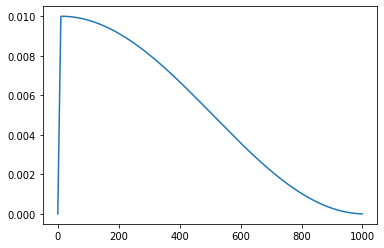

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rates)

In [ ]:
import tensorflow as tf

import time

def benchmark(dataset, num_epochs=1):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    tf.print("Execution time:", time.perf_counter() - start_time)

def train_classification_aug(img, lb, 
                             img_size=128, 
                             brightness_delta= 0.8,
                             contrast_delta  = 0.5,
                             saturation_delta= 0.5,
                             hue_delta       = 0.2,
                             max_rot_angle   = 45.):
  img = tf.cast(img, dtype=tf.float32)/255.
  IMG_SIZE = img_size

  angle_rad = max_rot_angle / 180. * np.pi

  padding = IMG_SIZE // 4
  precrop_shape = IMG_SIZE + padding

  img = tf.image.resize(img, (precrop_shape, precrop_shape))
  img = tf.image.random_crop(img, (256, IMG_SIZE, IMG_SIZE, 3))
  img = tf.image.random_brightness(img, brightness_delta)
  img = tf.image.random_contrast  (img, 1-contrast_delta,  1+contrast_delta)
  img = tf.image.random_saturation(img, 1-saturation_delta,1+saturation_delta)
  img = tf.image.random_hue       (img, hue_delta)

  img = tf.image.random_flip_left_right(img)
  img = tfa.image.rotate(img, (tf.random.uniform(shape=(1,)) - 0.5)*2 *angle_rad )

  img = tf.clip_by_value(img, 0., 1.0)
  return img, lb #tf.one_hot(lb, 4, )

def train_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(train_classification_aug(img, lb)[0])
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, NUM_CLASSES)

In [ ]:
benchmark(ds_test.map(train_data_aug, num_parallel_calls=tf.data.AUTOTUNE).batch(32))

ValueError: ignored

In [ ]:
benchmark(ds_test.batch(256).map(train_data_aug, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))

InvalidArgumentError: ignored